In [ ]:
!pip install gdown tqdm rank_bm25 pandas datasets matplotlib

In [ ]:
import gdown

# URL for the shared dataset
url = "https://drive.google.com/uc?id=1vpmbAT8Rm1WdMWyXcWHp35J6PiioCrgN"
output_path = "summarized_fever.jsonl"

# Download the file
gdown.download(url, output_path, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1vpmbAT8Rm1WdMWyXcWHp35J6PiioCrgN
From (redirected): https://drive.google.com/uc?id=1vpmbAT8Rm1WdMWyXcWHp35J6PiioCrgN&confirm=t&uuid=3b598328-41aa-446c-ad43-e438b9a09f05
To: /content/summarized_fever.jsonl
100%|██████████| 161M/161M [00:00<00:00, 177MB/s]


'summarized_fever.jsonl'

In [ ]:
import random
import pandas as pd
import json

# Function to load JSONL file
def load_jsonl(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        return [json.loads(line) for line in f]

# Function to create a balanced dataset
def create_balanced_dataset(dataset, max_samples_per_group=None):
    # Convert dataset to a DataFrame for easier processing
    df = pd.DataFrame(dataset)

    # Ensure required columns exist
    if "label" not in df.columns or "summarized" not in df.columns:
        raise ValueError("The dataset must contain 'true_label' and 'summarized' columns.")

    # Separate the data by true_label and summarization
    balanced_data = []
    labels = ["SUPPORTS", "REFUTES", "NOT ENOUGH INFO"]

    for label in labels:
        for summarized in [True, False]:
            # Filter the dataset for the current label and summarization
            group = df[(df["label"] == label) & (df["summarized"] == summarized)]

            # If max_samples_per_group is specified, sample from the group
            if max_samples_per_group:
                group = group.sample(n=min(max_samples_per_group, len(group)), random_state=42)

            # Add the group to the balanced data
            balanced_data.append(group)

    # Combine all groups and shuffle
    balanced_df = pd.concat(balanced_data).sample(frac=1, random_state=42).reset_index(drop=True)

    return balanced_df

# Load the full dataset
jsonl_file_path = "summarized_fever.jsonl"  # Replace with your file path
dataset = load_jsonl(jsonl_file_path)

# Create a balanced dataset
balanced_df = create_balanced_dataset(dataset, max_samples_per_group=5000)

# Save the balanced dataset to a new JSONL file
balanced_dataset_path = "balanced_dataset.jsonl"
balanced_df.to_json(balanced_dataset_path, orient="records", lines=True, force_ascii=False)
print(f"Balanced dataset saved to {balanced_dataset_path}")

# Display basic stats
print("\nBalanced Dataset Statistics:")
print(balanced_df.groupby(["label", "summarized"]).size())


Balanced dataset saved to balanced_dataset.jsonl

Balanced Dataset Statistics:
label            summarized
NOT ENOUGH INFO  False         5000
REFUTES          False         5000
                 True          5000
SUPPORTS         False         5000
                 True          5000
dtype: int64


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import pandas as pd
import torch
from datasets import Dataset
import json

# Load the tokenizer and model
model_name = "roberta-large-mnli"  # Replace with your model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

# Load the balanced dataset
balanced_dataset_path = "balanced_dataset.jsonl"
balanced_df = pd.read_json(balanced_dataset_path, lines=True)

# Map labels to integers
label_map = {"SUPPORTS": 2, "REFUTES": 0, "NOT ENOUGH INFO": 1}  # Map labels to integers

# Function to sanitize the DataFrame
def sanitize_dataframe(df, label_map):
    # Keep only relevant columns
    columns_to_keep = ["claim", "evidence_text", "label"]
    sanitized_df = df[columns_to_keep].copy()

    # Convert all data to correct types
    sanitized_df["claim"] = sanitized_df["claim"].astype(str)
    sanitized_df["evidence_text"] = sanitized_df["evidence_text"].astype(str)
    sanitized_df["label"] = sanitized_df["label"].map(label_map)  # Map labels using the label_map

    # Drop rows with unmapped labels (if any)
    sanitized_df = sanitized_df.dropna(subset=["label"])
    sanitized_df["label"] = sanitized_df["label"].astype(int)  # Ensure labels are integers
    return sanitized_df

# Sanitize the DataFrame
sanitized_df = sanitize_dataframe(balanced_df, label_map)

# Tokenize the dataset
def preprocess_function(examples):
    return tokenizer(
        examples["claim"],
        examples["evidence_text"],
        truncation=True,
        padding="max_length",
        max_length=512
    )

# Convert the sanitized DataFrame to HuggingFace Dataset
dataset = Dataset.from_pandas(sanitized_df)
tokenized_dataset = dataset.map(preprocess_function, batched=True)

# Split into train and validation sets
train_test_split = tokenized_dataset.train_test_split(test_size=0.2, seed=42)
train_dataset = train_test_split["train"]
val_dataset = train_test_split["test"]

# Define metrics for evaluation
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = torch.argmax(torch.tensor(logits), dim=-1).numpy()
    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average="weighted")
    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

# Training arguments
training_args = TrainingArguments(
    output_dir="./results",           # Directory for saving results
    evaluation_strategy="epoch",      # Evaluate after each epoch
    save_strategy="epoch",            # Save model after each epoch
    learning_rate=1e-5,               # Learning rate
    per_device_train_batch_size=8,    # Batch size for training
    per_device_eval_batch_size=8,     # Batch size for evaluation
    num_train_epochs=3,               # Number of epochs
    weight_decay=0.01,                # Weight decay for optimization
    logging_dir="./logs",             # Directory for logs
    logging_steps=100,                # Log every 100 steps
    load_best_model_at_end=True,      # Load the best model at the end
    metric_for_best_model="f1",       # Select the best model based on F1
    seed=42,                          # For reproducibility
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)

# Fine-tune the model
trainer.train()

# Evaluate the model on the validation set
results = trainer.evaluate()
print("Evaluation Results:", results)

# Save the fine-tuned model
model.save_pretrained("./fine_tuned_model")
tokenizer.save_pretrained("./fine_tuned_model")
print("Model saved to './fine_tuned_model'")


Some weights of the model checkpoint at roberta-large-mnli were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-11-14c293aaf79e>:84: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.336300,0.302176,0.915400,0.915596,0.915400,0.915226
2,0.220500,0.339639,0.917200,0.917422,0.917200,0.917274
3,0.124600,0.430502,0.922400,0.922657,0.922400,0.922399


Evaluation Results: {'eval_loss': 0.43050190806388855, 'eval_accuracy': 0.9224, 'eval_precision': 0.9226570877538379, 'eval_recall': 0.9224, 'eval_f1': 0.92239869484991, 'eval_runtime': 438.317, 'eval_samples_per_second': 11.407, 'eval_steps_per_second': 1.426, 'epoch': 3.0}
Model saved to './fine_tuned_model'


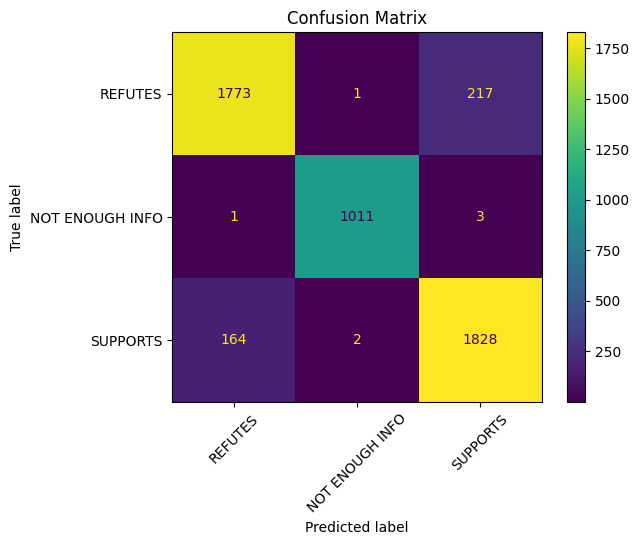

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt # Import the pyplot module

# Extract predictions and labels from the trainer
predictions, labels, _ = trainer.predict(val_dataset)
predicted_labels = torch.argmax(torch.tensor(predictions), dim=-1).numpy()

# Generate confusion matrix
cm = confusion_matrix(labels, predicted_labels, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["REFUTES", "NOT ENOUGH INFO", "SUPPORTS"])
disp.plot(cmap="viridis", xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()


In [ ]:
import shutil
from google.colab import files

# Path to the fine-tuned model directory
model_dir = "./fine_tuned_model"

# Output zip file name
zip_file = "fine_tuned_model.zip"

# Zip the directory
shutil.make_archive(zip_file.replace(".zip", ""), 'zip', model_dir)

# Download the zip file
files.download(zip_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>